# Bose-Hubbard 模型的平均场解


### Bose-Hubbard 模型 {#bose-hubbard-模型}

[Bose-Hubbard 模型](https://en.wikipedia.org/wiki/Bose%E2%80%93Hubbard%5Fmodel) 是一维的无自旋玻色子格点模型。

哈密顿量为

$$
H = -t \sum\_{\langle i,j \rangle} b^{\dagger}\_{i}b\_{j} + \frac{U}{2} \sum\_{i} n\_{i} (n\_{i} -1) - \mu \sum\_{i} n\_{i}
$$

其中 $-t$ 是最近邻跃迁强度， $U$ 是相互作用强度， $\mu$ 是化学势。


### 平均场哈密顿量 

平均场近似为
$$
a^{\dagger}\_{i} a\_{j} = \langle a^{\dagger}\_{i} \rangle a\_{j} + a^{\dagger}\_{i} \langle a\_{j} \rangle - \langle a^{\dagger}\_{i} \rangle \langle a\_{j} \rangle
$$

代入就得到单点平均场哈密顿量
$$
H\_{i}^{\mathrm{MF}} = \frac{U}{2} n\_{i} (n\_{i} -1) - \mu n\_{i} - \psi (a\_{i} + a\_{i}^{\dagger}) + |\psi|
$$

其中 $\psi = \langle a^{\dagger}\_{i} \rangle = \langle a\_{i} \rangle $ 是超流序参量。


### 求解

由于是玻色模型，所以需要先确定合适的截断尺寸。步骤就是先计算小的截断尺寸的基态能量，再逐渐加大截断数直到收敛。

确定截断之后就把 $\psi$ 做自变量，寻找能使基态能量最小的 $\psi$ ，迭代自洽收敛的效果很好，直接做优化则很难找到全局最优。

得到不同参数的 $\psi$ 再计算 $\langle n \rangle$ 两个对比，就能看到超流相和 Mott 绝缘体相之间的变化，以及化学势导致的不同 Mott 平台。


### 参考文献 

1.  首先给出 Bose-Hubbard 模型的平均场解的是 ([Sheshadri et al. 1993](#org02ecd18)) .
    Sheshadri, K., H. R. Krishnamurthy, R. Pandit, and T. V. Ramakrishnan. 1993. “Superfluid and Insulating Phases in an Interacting-Boson Model: Mean-Field Theory and the RPA.” Europhysics Letters (EPL) 22 (4). IOP Publishing:257–63.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as sop
import scipy.sparse as sp
import scipy.sparse.linalg as slin
from tqdm.notebook import tqdm

In [2]:
def dag(x):
    return x.T.conj()


def annihilation(M, tp="dense"):
    if tp == "dense":
        a = np.diag(np.sqrt(np.arange(1, M)), k=1)
    elif tp == "sparse":
        a = sp.dia_matrix((np.sqrt(np.arange(1, 10)), 1), shape=(M, M))
    return a

In [3]:
def make_Hi(U, t, mu, psi, M, tp):
    a = annihilation(M, tp)
    ad = dag(a)
    n = ad @ a
    if tp == "dense":
        mI = np.eye(M)
    elif tp == "sparse":
        mI = sp.eye(M)
    Hi = U / 2 * n @ (n - mI) - mu * n + psi * (a + ad) + np.abs(psi) ** 2 * mI
    return Hi


def eig_Hi(Hi, tp):
    if tp == "dense":
        eigvals, eigvecs = np.linalg.eigh(Hi)
        e = eigvals[0]
        v = eigvecs[:, 0].reshape((-1, 1))
    elif tp == "sparse":
        el, v = slin.eigsh(Hi, which="SA", k=1)
        e = el[0]
    return e, v


def calc_psi(v, tp):
    M = v.shape[0]
    a = annihilation(M, tp)
    return (dag(v) @ a @ v)[0, 0]


def find_M(U, mu, t, psi, tp):
    e_old = None
    for M in range(5, 50):
        Hi = make_Hi(U, t, mu, psi, M, tp)
        e, v = eig_Hi(Hi, tp)
        # psi=calc_psi(v,tp)
        # print(M,e)
        if e_old is not None:
            if np.abs(e - e_old) < 1e-6:
                break
        e_old = e
    return M


def find_psi(U, mu, t, M, tp):
    psi = np.random.rand()
    e_old = None
    for i in range(30):

        Hi = make_Hi(U, t, mu, psi, M, tp)
        e, v = eig_Hi(Hi, tp)
        psi = calc_psi(v, tp)
        # print(e,e_old)
        if e_old is None:
            e_old = e
        else:
            if np.abs(e - e_old) < 1e-6:
                break
            else:
                e_old = e

    return e, psi, v


def find_psi_variational(U, mu, t, M, tp):
    def _f(psi, U, t, mu, M, tp):
        Hi = make_Hi(U, t, mu, psi, M, tp)
        e, v = eig_Hi(Hi, tp)
        return e

    sol = sop.minimize(f, np.random.rand(), args=(U, mu, t, M, tp))

    Hi = make_Hi(U, t, mu, sol.x[0], M, tp)
    e, v = eig_Hi(Hi, tp)
    return e, sol.x[0], v


def calc_n(v, tp):
    M = v.shape[0]
    a = annihilation(M, tp)
    ad = dag(a)
    n = ad @ a
    return (dag(v) @ n @ v)[0, 0]

In [4]:
tp = "dense"

In [5]:
t = 1

Ul = np.linspace(0, 20, 40)
mul = np.linspace(0, 40, 150)

UU, mumu = np.meshgrid(Ul, mul, indexing="ij")
ee = np.zeros_like(UU)
psipsi = np.zeros_like(UU)
nn = np.zeros_like(UU)

In [6]:
for i in tqdm(range(len(Ul))):
    for j in range(len(mul)):
        U = UU[i, j]
        mu = mumu[i, j]
        M = find_M(U, mu, t, 0.5, tp)
        e, psi, v = find_psi(U, mu, t, M, tp)
        ee[i, j] = e
        psipsi[i, j] = psi
        nn[i, j] = calc_n(v, tp)

  0%|          | 0/40 [00:00<?, ?it/s]

这就是巨正则系统的相图，右边圈起来的地方就是 Mott 绝缘体相

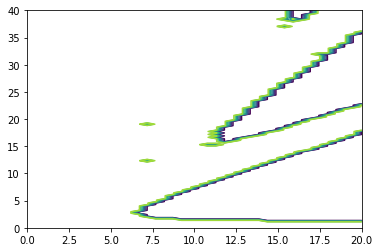

In [7]:
pp = psipsi.copy()
pp[np.abs(pp) < 1e-2] = 0
pp[np.abs(pp) >= 1e-2] = 1
plt.contour(UU, mumu, np.abs(pp))

In [8]:
mul = np.linspace(-4, 40, 150)
el = np.zeros_like(mul)
psil = np.zeros_like(mul)
nl = np.zeros_like(mul)
t = 1
U = 20
for i in range(len(mul)):
    mu = mul[i]
    M = find_M(U, mu, t, 0.5, tp)
    e, psi, v = find_psi(U, mu, t, M, tp)
    # e, psi, v = find_psi_variational(U, mu, t, M, tp)
    el[i] = e
    psil[i] = psi
    nl[i] = calc_n(v, tp)

对某个特定参数，能够看到在 Mott 平台中超流序参量都是 0，在Mott平台之间超流序参量才不是 0.

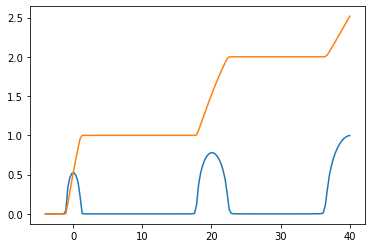

In [9]:
plt.plot(mul, np.abs(psil))
plt.plot(mul, nl)